# Player detection Tennis

## Court detection

First we implement a code to detect the court lines.

We use the 2023 Wimbledon final between Djokovic and Alcaraz.

Frame shape: (720, 1280, 3)


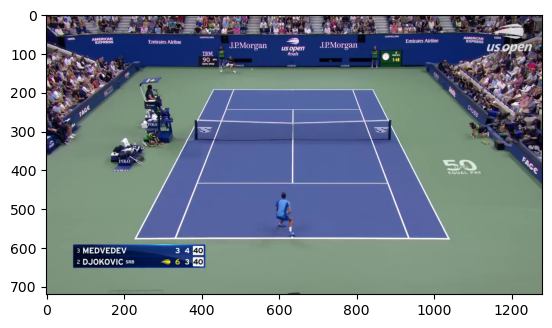

In [64]:
import cv2
import matplotlib.pyplot as plt

video_path = 'Medvedev_Djokovic_2023_US_Open_Final.mp4'

cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
frame_number = 15 * 60 * fps  # Calculate frame number for 20th minute

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)  # Set the position of the video file to the desired frame

ret, frame = cap.read()

cv2.imwrite('image.jpg', frame)  # Save the frame as an image

frame_shape = frame.shape
print(f"Frame shape: {frame_shape}")
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert color space for matplotlib
    plt.imshow(frame)
    plt.show()
else:
    print("Couldn't retrieve frame.")

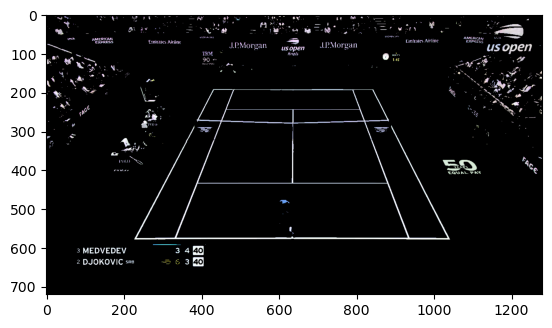

In [48]:
# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Définir un seuil de luminosité pour déterminer les pixels blancs
seuil = 170

# Créer un masque pour les pixels suffisamment blancs
mask = cv2.threshold(gray_image, seuil, 255, cv2.THRESH_BINARY)[1]

# Appliquer le masque à l'image d'origine
result = cv2.bitwise_and(frame, frame, mask=mask)

plt.imshow(result)

In [49]:
import numpy as np

# def detect_lines(image, tau, threshold):
#     # Convert the image to grayscale
#     if len(image.shape) == 3:
#         # Convert the image to grayscale
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image
#     # Initialize an empty image to store the result
#     result = np.zeros_like(gray)
    
#     # Loop through each pixel in the image
#     for i in range(len(gray)):
#         for j in range(len(gray[0])):
#             pixel_intensity = gray[i, j]
            
#             # Check if the pixel belongs to a vertical line
#             if j + tau < len(gray[0]) and j - tau >= 0:
#                 if (pixel_intensity - gray[i, j + tau] > threshold) and (pixel_intensity - gray[i, j - tau] > threshold):
#                     result[i, j] = 255
#             # Check if the pixel belongs to a horizontal line
#             if i + tau < len(gray) and i - tau >= 0:
#                 if (pixel_intensity - gray[i + tau, j] > threshold) and (pixel_intensity - gray[i - tau, j] > threshold):
#                     result[i, j] = 255
            
                    
#     return result

In [50]:
# update_result = detect_lines(result, 3, 150)
# plt.imshow(update_result, cmap='gray')

## Line detection

32


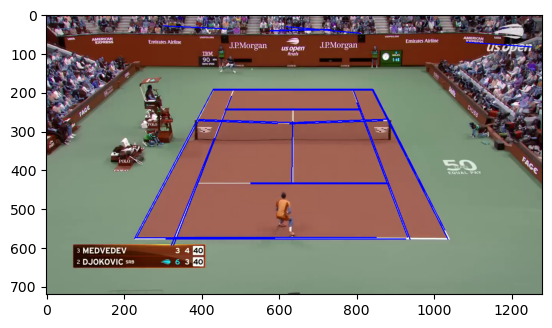

In [51]:
edges = cv2.Canny(result, 50, 150, apertureSize=3)

# Apply Probabilistic Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=150, maxLineGap=30)

# Create a copy of the original image to draw lines on
line_image = np.copy(frame)

# Draw each line
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

print(len(lines))
plt.imshow(line_image)
plt.show()

### Horizontal, left-vertical and right-vertical lines

In [52]:
def line_classification(lines, frame_shape):
    left_vertical_lines = []
    right_vertical_lines = []
    horizontal_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = np.abs(x2 - x1)
        dy = np.abs(y2 - y1)
        if dx < dy:
            if min(x1, x2) < frame_shape[1] / 3:
                left_vertical_lines.append(line)
            elif max(x1, x2) > 2 * frame_shape[1] / 3:
                right_vertical_lines.append(line)
        else:
            horizontal_lines.append(line)
            
    return left_vertical_lines, right_vertical_lines, horizontal_lines

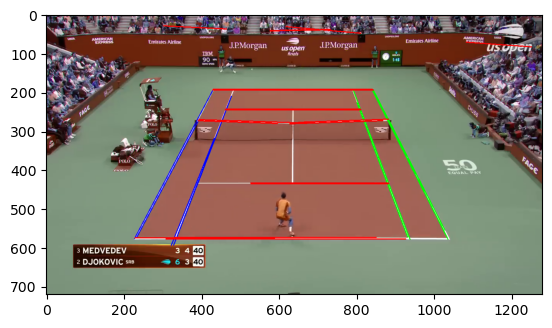

In [53]:
def draw_lines(image, lines, color):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), color, 2)

# Assuming 'lines' is the output of cv2.HoughLinesP()
left_vertical_lines, right_vertical_lines, horizontal_lines = line_classification(lines, frame.shape)

# Create a copy of the original image to draw lines on
line_image = np.copy(frame)

# Draw lines on the image
draw_lines(line_image, left_vertical_lines, (255, 0, 0))  # Red for left vertical lines
draw_lines(line_image, right_vertical_lines, (0, 255, 0))  # Green for right vertical lines
draw_lines(line_image, horizontal_lines, (0, 0, 255))  # Blue for horizontal lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

### Merging lines

In [54]:
import numpy as np
from scipy.spatial.distance import cdist

def are_parallel(segment1, segment2, threshold_degrees=2):
    # Convertir les segments en vecteurs
    vector1 = np.array([segment1[0][0], segment1[0][1]]) - np.array([segment1[0][2], segment1[0][3]])
    vector2 = np.array([segment2[0][0], segment2[0][1]]) - np.array([segment2[0][2], segment2[0][3]])

    # Calculer les normes des vecteurs
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)

    # Calculer le produit scalaire des vecteurs
    dot_product = np.dot(vector1, vector2)

    # Calculer l'angle entre les vecteurs (en radians)
    angle_radians = np.arccos(dot_product / (norm1 * norm2))

    # Convertir l'angle en degrés
    angle_degrees = np.degrees(angle_radians)
    angle_degrees = min(angle_degrees, 180 - angle_degrees)
    # Vérifier si l'angle est inférieur au seuil
    if angle_degrees < threshold_degrees:
        return True
    else:
        return False


def leftmost_point_sort(lines):
    lines_sorted = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 < x2:
            lines_sorted.append(np.array([[x1, y1, x2, y2]]))
        else:
            lines_sorted.append(np.array([[x2, y2, x1, y1]]))
    return lines_sorted


def merge_horizontal_lines(lines):
    
    lines = leftmost_point_sort(lines)
    
    merged = False

    while not merged:
        #Tant qu'on peut merger des lignes
        merged_lines = []
        merged = True
        
        while len(lines) > 1:
            # Si il y a au moins 2 lignes à merger
            line_a = lines[0]
            i = 1
            pair_merged = False
            while i <= len(lines) - 1:
                # Pour chaque ligne, on regarde si on peut la merger avec la première
                line_b = lines[i]  

                # La ligne L est la ligne la plus à gauche
                if line_a[0][0] < line_b[0][0]:
                    L = line_a
                    R = line_b
                else:
                    L = line_b
                    R = line_a
                
                # On calcule si les lignes sont parallèles
                if are_parallel(L, R):
                    segment = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                    if are_parallel(L, segment, 1.5):
                        # On crée la ligne mergee
                        M = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                        
                        # On ajoute la ligne mergee à merged_lines
                        merged_lines.append(M)
                        
                        lines.pop(0)
                        lines.pop(i-1)
                        
                        merged = False
                        pair_merged = True

                        # On sort de la boucle
                        break
                    else:
                        # Si on ne peut pas merger les lignes on passe à la suivante
                        i += 1
                else:
                    # Si on ne peut pas merger les lignes on passe à la suivante
                    i += 1
            if not pair_merged:
                # Si on a parcouru toutes les lignes et qu'on a pas pu merger la première ligne avec une autre
                # On ajoute la première ligne à merged_lines et on la supprime de lines
                merged_lines.append(lines[0])
                lines.pop(0)
            
        if len(lines) == 1:
            # Si il reste une seule ligne à la fin on l'ajoute à merged_lines
            merged_lines.append(lines[0])
            lines.pop(0)
        lines = merged_lines

    return merged_lines

# Assuming 'horizontal_lines' is the list of horizontal lines
merged_horizontal_lines = merge_horizontal_lines(horizontal_lines)
print(merged_horizontal_lines)
print(len(merged_horizontal_lines))


[array([[229, 575, 852, 574]], dtype=int32), array([[430, 195, 842, 193]], dtype=int32), array([[528, 434, 884, 436]], dtype=int32), array([[462, 246, 811, 244]], dtype=int32), array([[392, 274, 675, 280]], dtype=int32), array([[628, 282, 884, 270]], dtype=int32), array([[ 303,   30, 1253,   84]], dtype=int32), array([[578,  42, 733,  39]], dtype=int32), array([[578,  43, 733,  40]], dtype=int32)]
9


C:\Users\marin\AppData\Local\Temp\ipykernel_21960\2308557075.py:17: RuntimeWarning: invalid value encountered in arccos
  angle_radians = np.arccos(dot_product / (norm1 * norm2))


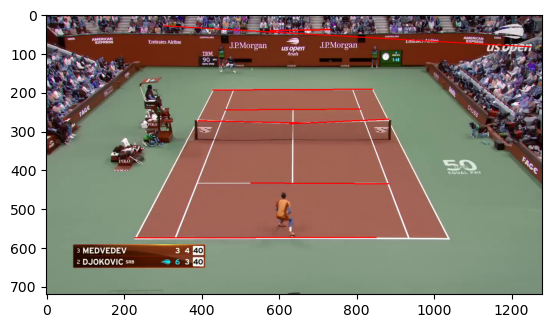

In [55]:
# Draw merged lines on the image
line_image = np.copy(frame)
draw_lines(line_image, merged_horizontal_lines, (0, 0, 255))  # Blue for merged horizontal lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

In [56]:
def bottom_most_point_sort(lines):
    lines_sorted = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if y1 < y2:
            lines_sorted.append(np.array([[x1, y1, x2, y2]]))
        else:
            lines_sorted.append(np.array([[x2, y2, x1, y1]]))
    return lines_sorted


def merge_vertical_lines(lines):
    lines = bottom_most_point_sort(lines)
    merged = False

    while not merged:
        #Tant qu'on peut merger des lignes
        merged_lines = []
        merged = True
        
        while len(lines) > 1:
            # Si il y a au moins 2 lignes à merger
            line_a = lines[0]
            i = 1
            pair_merged = False
            while i <= len(lines) - 1:
                # Pour chaque ligne, on regarde si on peut la merger avec la première
                line_b = lines[i]  

                # La ligne L est la ligne la plus basse
                if line_a[0][1] < line_b[0][1]:
                    L = line_a
                    R = line_b
                else:
                    L = line_b
                    R = line_a
                
                # On calcule si les lignes sont parallèles
                if are_parallel(L, R):
                    segment = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                    if are_parallel(L, segment):
                        # On crée la ligne mergee
                        M = np.array([[L[0][0], L[0][1], R[0][2], R[0][3]]])
                        
                        # On ajoute la ligne mergee à merged_lines
                        merged_lines.append(M)
                        
                        lines.pop(0)
                        lines.pop(i-1)
                        
                        merged = False
                        pair_merged = True

                        # On sort de la boucle
                        break
                    else:
                        # Si on ne peut pas merger les lignes on passe à la suivante
                        i += 1
                else:
                    # Si on ne peut pas merger les lignes on passe à la suivante
                    i += 1
            if not pair_merged:
                # Si on a parcouru toutes les lignes et qu'on a pas pu merger la première ligne avec une autre
                # On ajoute la première ligne à merged_lines et on la supprime de lines
                merged_lines.append(lines[0])
                lines.pop(0)
            
        if len(lines) == 1:
            # Si il reste une seule ligne à la fin on l'ajoute à merged_lines
            merged_lines.append(lines[0])
            lines.pop(0)
        lines = merged_lines

    return merged_lines

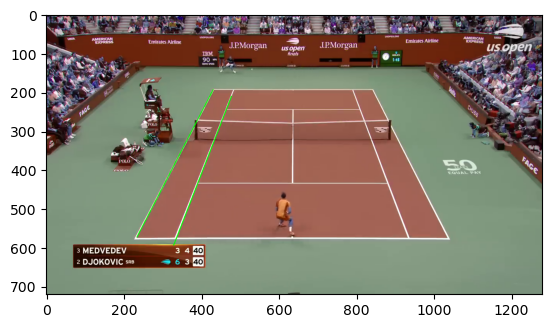

In [57]:
# Assuming 'vertical_lines' is the list of vertical lines
merged_left_vertical_lines = merge_vertical_lines(left_vertical_lines)
# Draw merged lines on the image
line_image = np.copy(frame)
draw_lines(line_image, merged_left_vertical_lines, (0, 255, 0))  # Green for merged vertical lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

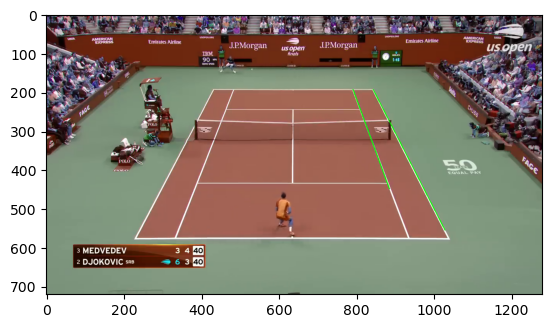

In [58]:
# Assuming 'vertical_lines' is the list of vertical lines
merged_right_vertical_lines = merge_vertical_lines(right_vertical_lines)

# Draw merged lines on the image
line_image = np.copy(frame)
draw_lines(line_image, merged_right_vertical_lines, (0, 255, 0))  # Green for merged vertical lines

# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

2
2
9


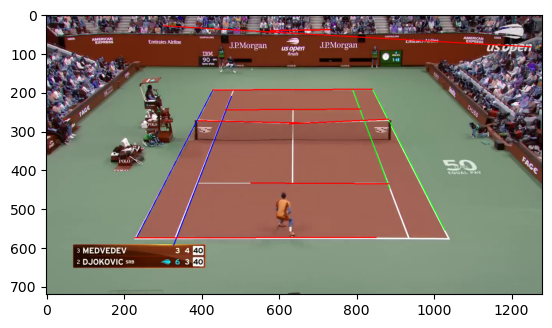

In [59]:
# Create a copy of the original image to draw lines on
line_image = np.copy(frame)

# Draw lines on the image
draw_lines(line_image, merged_left_vertical_lines, (255, 0, 0))  # Red for left vertical lines
draw_lines(line_image, merged_right_vertical_lines, (0, 255, 0))  # Green for right vertical lines
draw_lines(line_image, merged_horizontal_lines, (0, 0, 255))  # Blue for horizontal lines

print(len(merged_left_vertical_lines))
print(len(merged_right_vertical_lines)) 
print(len(merged_horizontal_lines)) 
# Convert color space for matplotlib
line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)

plt.imshow(line_image)
plt.show()

In [60]:
def intersection_segment(segment1, segment2):
    x1, y1, x2, y2 = segment1
    x3, y3, x4, y4 = segment2

    # Calcul des coordonnées du point d'intersection
    px_num = ((x1*y2 - y1*x2) * (x3-x4) - (x1-x2) * (x3*y4 - y3*x4))
    py_num = ((x1*y2 - y1*x2) * (y3-y4) - (y1-y2) * (x3*y4 - y3*x4))
    den = (x1-x2) * (y3-y4) - (y1-y2) * (x3-x4)
    
    px = px_num / den
    py = py_num / den

    return (px, py)
    


In [61]:
def four_intersections(vertical_lines, horizontal_lines):
    intersections = []
    for v_line in vertical_lines:
        for h_line in horizontal_lines:
            intersection = intersection_segment(v_line[0], h_line[0])
            intersections.append(intersection)
    return intersections

In [62]:
four = four_intersections([merged_right_vertical_lines[1]], [merged_horizontal_lines[1]])
print(four)

[(791.7213438735178, 193.24407114624506)]


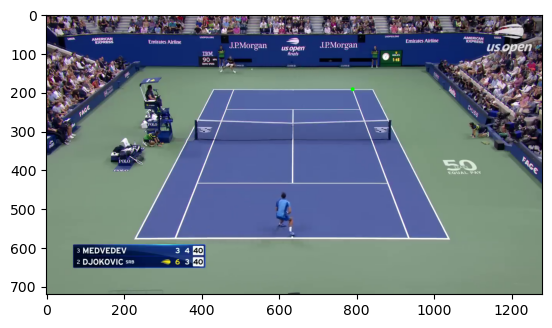

In [63]:
for point in four:
    center = tuple(int(x) for x in point)
    cv2.circle(frame, center, 5, (0, 255, 0), -1)  # Green circle

plt.imshow(frame)